# COVID-19 cases in Mexican States and factors

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin1_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin1.parquet'

In [4]:
resp = urlopen(admin1_url)
admin1 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin1.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin1['area_sqkm'] = admin1['geometry'].area/ 10**6

In [7]:
admin1['CVE_ENT'] = admin1['CVE_ENT']+['000']

In [8]:
admin1.rename(columns={"CVE_ENT":"cve_ent"},
                                  inplace=True)

In [9]:
admin1.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986


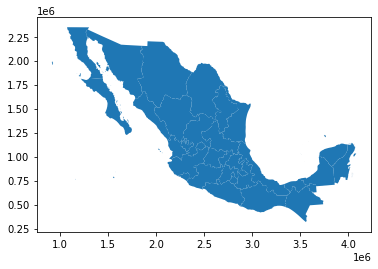

In [10]:
admin1.plot();

## Map of Population by State

Get population from COVID-19 data files

In [11]:
All_admin1 = pd.read_csv('../Data/ComorbilitiesStates.csv')
All_admin1.head()

,cve_ent,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,1000,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478
1,2000,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848
2,3000,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750
3,4000,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917
4,5000,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806


In [12]:
totalcases_admin1 =All_admin1[["cve_ent", "state", "total_cases"]]

In [13]:
totalcases_admin1.head()

,cve_ent,state,total_cases
0,1000,AGUASCALIENTES,26695
1,2000,BAJA CALIFORNIA,50286
2,3000,BAJA CALIFORNIA SUR,36317
3,4000,CAMPECHE,11099
4,5000,COAHUILA,69397


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [14]:
totalcases_admin1['cve_ent'] = totalcases_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-14-00c04cd03364>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalcases_admin1['cve_ent'] = totalcases_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [15]:
totalcases_admin1.head()

,cve_ent,state,total_cases
0,01000,AGUASCALIENTES,26695
1,02000,BAJA CALIFORNIA,50286
2,03000,BAJA CALIFORNIA SUR,36317
3,04000,CAMPECHE,11099
4,05000,COAHUILA,69397


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [16]:
df_admin1 = admin1.merge(totalcases_admin1, on='cve_ent')

In [17]:
df_admin1.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,total_cases
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,26695
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,50286
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,36317
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,11099
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,69397


### Calculate Total COVID-19 cases by State

In [18]:
#df_admin2['population_density'] = df_admin2['poblacion'] / df_admin2['area_sqkm']

In [19]:
a2 = df_admin1[['total_cases']]

In [20]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0
0,-0.586630
1,0.047541
2,-0.327973
3,-1.005880
4,0.561281
5,-0.976068
6,-0.979966
7,0.241090
8,16.805180
9,-0.374451


In [21]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 5
Silhouette Coefficient: 0.689


In [22]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [23]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [24]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,total_cases,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,26695,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,50286,0
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,36317,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,11099,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,69397,0


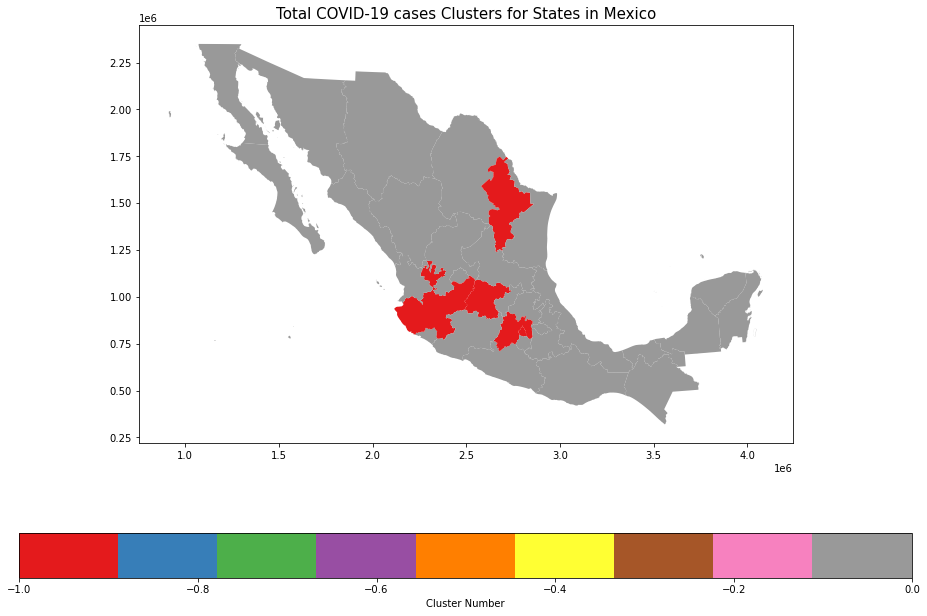

In [25]:
title = 'Total COVID-19 cases Clusters for States in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [26]:
# try Plotly with KDE density plot
# bubble maps (see Ebola example with time series):
# https://plotly.com/python/bubble-maps/

Plot population data

### Calculate rate of cases by State

In [27]:
rcases_admin1 =All_admin1[["cve_ent", "state", "cases_rates"]]

In [28]:
rcases_admin1['cve_ent'] = rcases_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-28-228958907396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rcases_admin1['cve_ent'] = rcases_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [29]:
dfrc_admin1 = admin1.merge(rcases_admin1, on='cve_ent')

In [30]:
a2 = dfrc_admin1[['cases_rates']]

In [31]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0
0,0.276714
1,-0.259518
2,3.256396
3,-0.567582
4,0.608453
5,-0.066938
6,-1.577213
7,-0.114861
8,6.577963
9,0.265331


In [32]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 7
Silhouette Coefficient: 0.537


In [33]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [34]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [35]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,total_cases,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,26695,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,50286,0
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,36317,-1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,11099,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,69397,0


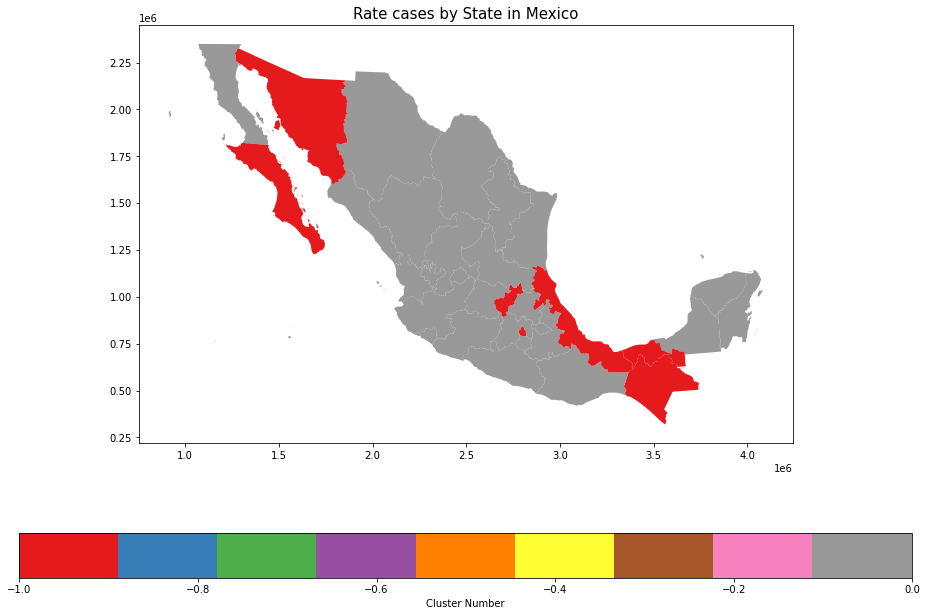

In [36]:
title = 'Rate cases by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate Total Deaths by State

In [37]:
deaths_admin1 =All_admin1[["cve_ent", "state", "total_deaths"]]

In [38]:
deaths_admin1['cve_ent'] = deaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-38-c77330a006c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_admin1['cve_ent'] = deaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [39]:
dfd_admin1 = admin1.merge(deaths_admin1, on='cve_ent')

In [40]:
a3 = dfd_admin1[['total_deaths']]

In [41]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.477867
1,0.754004
2,-0.670845
3,-0.714613
4,0.301999
5,-0.725754
6,-0.637223
7,0.524222
8,5.889386
9,-0.470108


In [42]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 1
Estimated number of noise points: 7
Silhouette Coefficient: 0.621


In [43]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [44]:
df2 = pd.concat([dfd_admin1, df_labels], axis=1)

In [45]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,total_deaths,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,2456,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,8648,0
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,1486,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1266,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,6376,0


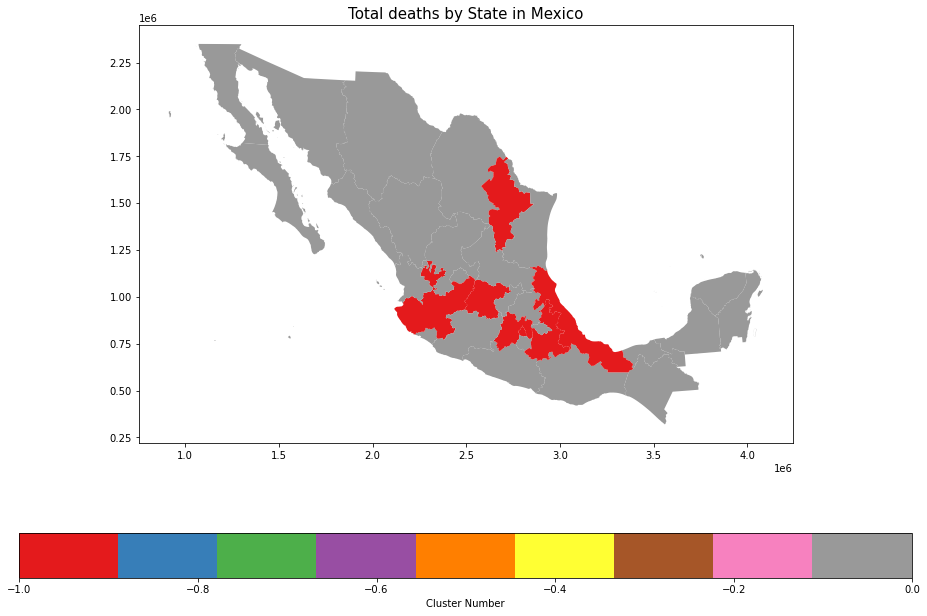

In [46]:
title = 'Total deaths by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate rate of deaths by State

In [47]:
rdeaths_admin1 =All_admin1[["cve_ent", "state", "deaths_rates"]]

In [48]:
rdeaths_admin1['cve_ent'] = rdeaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-48-b21e7ee3d26d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdeaths_admin1['cve_ent'] = rdeaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [49]:
dfd_admin1 = admin1.merge(rdeaths_admin1, on='cve_ent')

In [50]:
a3 = dfd_admin1[['deaths_rates']]

In [51]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.039183
1,1.253323
2,0.221739
3,-0.904505
4,0.481849
5,-0.370100
6,-2.795883
7,0.462786
8,4.046409
9,-0.769448


In [52]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 1
Estimated number of noise points: 5
Silhouette Coefficient: 0.538


In [53]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [54]:
df2 = pd.concat([dfd_admin1, df_labels], axis=1)

In [55]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,deaths_rates,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,171.193370,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,237.917856,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,184.663257,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,126.521936,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,198.091167,0


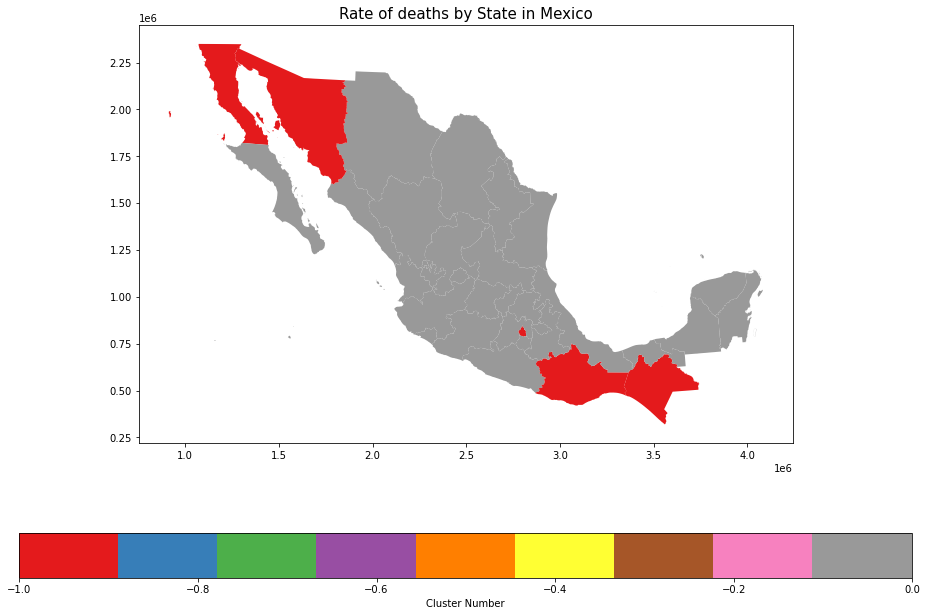

In [56]:
title = 'Rate of deaths by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Obesity) by State

In [57]:
obesity_admin1 =All_admin1[["cve_ent", "state", "pct_obesity_up20years"]]

In [58]:
obesity_admin1['cve_ent'] = obesity_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-58-14c1c3fa18f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesity_admin1['cve_ent'] = obesity_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [59]:
dfd_admin1 = admin1.merge(obesity_admin1, on='cve_ent')

In [60]:
a3 = dfd_admin1[['pct_obesity_up20years']]

In [61]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.444427
1,1.277162
2,0.674921
3,0.899177
4,0.102746
5,0.712138
6,-0.841576
7,0.218491
8,-0.035530
9,0.100125


In [62]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 1
Estimated number of noise points: 2
Silhouette Coefficient: 0.408


In [63]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [64]:
df2 = pd.concat([dfd_admin1, df_labels], axis=1)

In [65]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,pct_obesity_up20years,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,32.593387,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,48.366995,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,42.849118,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,44.903811,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,37.606715,0


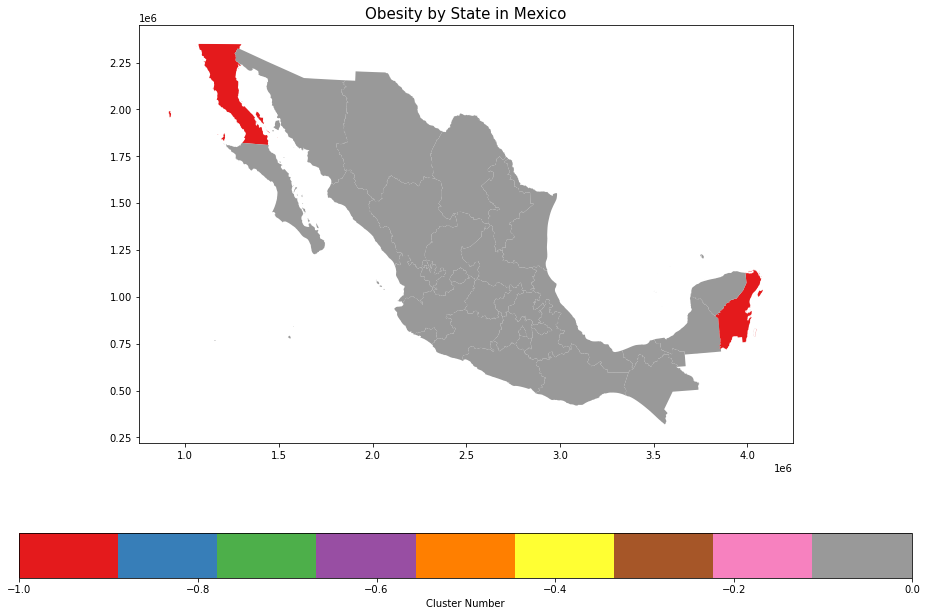

In [66]:
title = 'Obesity by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Hypertension) by State

In [67]:
hypertension_admin1 =All_admin1[["cve_ent", "state", "pct_hypertension_up20years"]]

In [68]:
hypertension_admin1['cve_ent'] = hypertension_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-68-80ab304c1ba4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypertension_admin1['cve_ent'] = hypertension_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [69]:
dfd_admin1 = admin1.merge(hypertension_admin1, on='cve_ent')

In [70]:
a3 = dfd_admin1[['pct_hypertension_up20years']]

In [71]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.889149
1,0.696219
2,-0.427564
3,1.978270
4,1.045570
5,-0.255126
6,-0.504005
7,1.097011
8,0.495071
9,0.505694


In [72]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 2
Estimated number of noise points: 6
Silhouette Coefficient: 0.387


In [73]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [74]:
df2 = pd.concat([dfd_admin1, df_labels], axis=1)

In [75]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,pct_hypertension_up20years,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,14.700566,1
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,21.007712,0
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,16.536911,1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,26.108154,-1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,22.397551,0


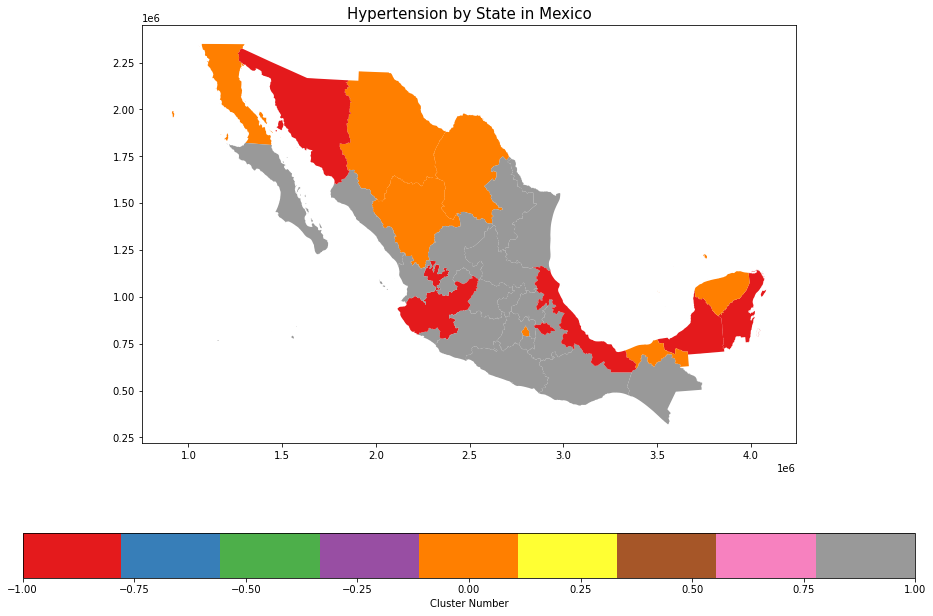

In [76]:
title = 'Hypertension by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Diabetes) by State

In [77]:
diabetes_admin1 =All_admin1[["cve_ent", "state", "pct_diabetes_up20years"]]

In [78]:
diabetes_admin1['cve_ent'] = diabetes_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

<ipython-input-78-c19dea4d84b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_admin1['cve_ent'] = diabetes_admin1['cve_ent'].apply(lambda i: f'{i:05d}')


In [79]:
dfd_admin1 = admin1.merge(diabetes_admin1, on='cve_ent')

In [80]:
a3 = dfd_admin1[['pct_diabetes_up20years']]

In [81]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-1.136044
1,-0.257382
2,-0.840559
3,1.207947
4,0.603328
5,0.052348
6,-1.051067
7,-0.520719
8,0.720222
9,0.078843


In [82]:
# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=5).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 3
Estimated number of noise points: 1
Silhouette Coefficient: 0.556


In [83]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [84]:
df2 = pd.concat([dfd_admin1, df_labels], axis=1)

In [85]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,pct_diabetes_up20years,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,7.556478,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,9.974848,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,8.369750,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,14.007917,-1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,12.343806,2


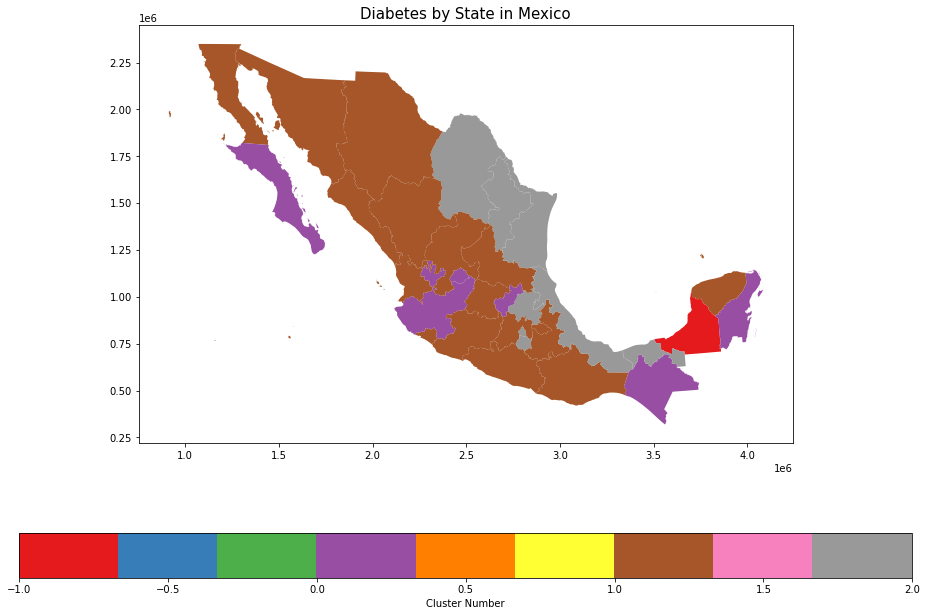

In [86]:
title = 'Diabetes by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='Set1',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);